## Gaussian Process from scratch with Tensorflow

This is a naive implementation of Gaussian Process in Tensorflow.

### Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import numpy as np
import tensorflow as tf
from IPython.display import HTML
import csv
jitter = 1e-7

### Utils

In [2]:
# Help function for computing the Cholesky decomposition with added jitter for stability


@tf.function
def cholesky(X):
    """Cholesky with added jitter on the diagonal for stability

    Args:
        X (tf.Tensor): Matrix to be decomposed

    Returns:
        L (tf.Tensor): Lower matrix L where X = LL^T


    """
    return tf.linalg.cholesky(X + tf.eye(X.shape[0], dtype=tf.float64) * jitter)


@tf.function
def KL(m0, L0, m1, L1):
    """KL divergence between two Gausisans  N0(m0, S0), N1(m1, S1)

    Args:
        m0 (tf.Tensor): mean vector of N0 (N x 1)
        L0 (tf.Tensor): Cholesky decomposition of S0 (N x N)
        m1 (tf.Tensor): mean vector of N1 (N x 1)
        L1 (tf.Tensor): Cholesky decomposition of S1 (N x N)

    Returns:
        KL divergence (scalar)

    """
    N = tf.cast(m0.shape[0], tf.float64)

    # Ensure triangularity
    L0 = tf.linalg.band_part(L0, -1, 0)
    L1 = tf.linalg.band_part(L1, -1, 0)

    #
    A = tf.reduce_sum(tf.math.pow(
        tf.linalg.triangular_solve(L1, L0), 2))  # Compute L1_inv @ L0
    B_1 = tf.linalg.triangular_solve(L1, (m1 - m0))
    B = tf.reduce_sum(tf.transpose(B_1) @ B_1) - N
    C = 2 * tf.reduce_sum(
        tf.math.log(tf.math.abs(tf.linalg.tensor_diag_part(L0)))
        - tf.math.log(tf.math.abs(tf.linalg.tensor_diag_part(L1)))
    )
    return 1 / 2 * (A + B + C)


@tf.function
def ncdf(x):
    """Cumulative distribution function for the standard (multivariate) normal distribution.
    (Used for squashing)

    Args:
        x (tf.Tensor): evaluation points

    Returns:
        (tf.Tensor): cumulative distribution function evaluated at x

    """
    return (1 + tf.math.erf(x / np.sqrt(2))) / 2


@tf.function
def classif_log_likelihood(f, y):
    """log p(y|f) for classification using the normal cdf
    log p(y|f) = log phi(y * f)
    """
    return tf.math.log(ncdf(y * f) + 1e-7)

### Kernel function

In [3]:


class RBF:
    def __init__(self, alpha=1, scale=1) -> None:
        """Squared exponential kernel between two data matrix A and B
        Args:
            alpha, scale (float|tf.Variable): hyperparameters of the kernel
        """
        self.alpha = tf.Variable(alpha, dtype=tf.float64)
        self.scale = tf.Variable(scale, dtype=tf.float64)
        self.parameters = [self.alpha, self.scale]

    def __call__(self, A, B):
        """
        Args:
            A (tf:Tensor): data matrix A (N x D)
            B (tf:Tensor): data matrix B (M x D)

        Returns:
            (scalar)

        """
        AA = tf.reshape(tf.reduce_sum(A * A, 1), (-1, 1))
        BB = tf.reshape(tf.reduce_sum(B * B, 1), (-1, 1))
        D = AA - 2 * A @ tf.transpose(B) + tf.transpose(BB)
        return self.alpha * tf.exp(-D / (2 * tf.pow(self.scale, 2)))

## Sparse Variational Gaussian Process (SVGP) model

In [4]:
class SVGP:
    def __init__(
        self,
        data,
        kernel,
        likelihood,
        ns=10,
        lr=0.0005,
        n_gh=10,
        X_s_init=None,
        silent=False,
    ):
        self.X, self.y = data
        self.llh = likelihood
        self.kernel = kernel
        self.ns = ns
        self.optimizer = tf.optimizers.Adam(learning_rate=lr)
        self.num_steps = num_steps
        self.variables = []
        self.silent = silent

        # for Gaussian-Hermite quadrature approximation
        GQ_t, GQ_w = np.polynomial.hermite.hermgauss(n_gh)
        self.GQ_w = tf.reshape(tf.constant(
            GQ_w, dtype=tf.float64), (1, -1))  # 1 x m
        self.GQ_t = tf.reshape(tf.constant(
            GQ_t, dtype=tf.float64), (1, -1))  # 1 x m

        # initialize inducing points
        if X_s_init is not None:
            ns = X_s_init.shape[0]
        else:
            X_s_init = X[np.random.choice(X.shape[0], ns), :]

        self.X_s = tf.Variable(X_s_init, dtype=tf.float64)

        # reparameterization vector u ~ N(m_u, Sigma_u)
        self.m_u = tf.Variable(np.zeros((ns, 1)), dtype=tf.float64)
        self.L_u = tf.Variable(np.eye(ns), dtype=tf.float64)

        self.variables = [self.X_s, self.m_u,
                          self.L_u, *self.kernel.parameters]

    def expected_log_likelihood(self, means, mvars, y):
        stds = tf.reshape(tf.sqrt(mvars), (-1, 1))  # 1 x N
        f = means + np.sqrt(2) * stds @ self.GQ_t  # N x m
        aprox_terms = self.GQ_w / np.sqrt(2) * self.llh(f, y)  # N x m
        return tf.reduce_sum(aprox_terms, axis=1)  # N x 1

    def _predict_f(self, X_new, X, m_q, L_q):
        # ensure triangularity
        L_q = tf.linalg.band_part(L_q, -1, 0)

        K_fsf = self.kernel(X_new, X)
        K_ff = self.kernel(X, X)
        K_fsfs = self.kernel(X_new, X_new)

        inv = tf.linalg.inv(K_ff)
        pos_m = K_fsf @ inv @ m_q
        pos_var = tf.linalg.tensor_diag_part(
            K_fsfs
            - K_fsf @ inv @ (K_ff - L_q @ tf.transpose(L_q)
                             ) @ inv @ tf.transpose(K_fsf)
        )
        return pos_m, tf.reshape(pos_var, (-1, 1))

    def posterior(self):
        L_ps = cholesky(self.kernel(self.X_s, self.X_s))
        m_qs = L_ps @ self.m_u
        V = L_ps @ self.L_u
        L_qs = V @ tf.transpose(V)
        return m_qs, L_qs @ tf.transpose(L_qs)

    def predict_f(self, X_new):
        return self._predict_f(X_new, self.X_s, *self.posterior())

    def elbo(self):
        # prior
        m_ps = tf.constant(np.zeros((self.ns, 1)))
        L_ps = cholesky(self.kernel(self.X_s, self.X_s))

        # whitening
        m_qs = L_ps @ self.m_u
        V = L_ps @ self.L_u
        L_qs = V @ tf.transpose(V)

        #
        q_means, q_vars = self._predict_f(self.X, self.X_s, m_qs, L_qs)
        ve = tf.reduce_sum(
            self.expected_log_likelihood(q_means, q_vars, self.y))
        kl = KL(m_qs, L_qs, m_ps, L_ps)

        return ve - kl

    def loss(self):
        return -self.elbo()

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            tape.watch(self.variables)
            loss_value = self.loss()
        gradients = tape.gradient(loss_value, self.variables)
        self.optimizer.apply_gradients(zip(gradients, self.variables))

    def train(self, num_steps):
        losses = []
        inducing_points = []
        posteriors = []
        for step in range(num_steps):
            self.train_step()
            if step % 500 == 0:
                l = tf.reduce_mean(self.loss()).numpy()
                losses.append(l)
                inducing_points.append(self.X_s.numpy())
                posteriors.append(self.posterior())
                if not self.silent:
                    print(step, "avg_loss: ", l)

        return losses, inducing_points, posteriors

### Training
`banana.csv` dataset is used.

Text(0.5, 1.0, 'Classification data')

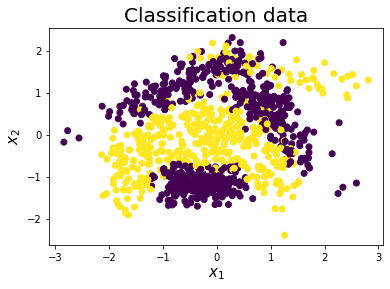

In [5]:
# Data
XY = []
with open("banana.csv") as csvfile:
    # change contents to floats
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:  # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember, computation scales as N^3)
np.random.shuffle(XY)
N = 1000
X, Y = XY[:N, :-1], XY[:N, -1:]
Y = (Y - 1.5) * 2  # to be in {-1, 1}
N = X.shape[0]

# Plotting the data

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.title("Classification data", fontsize=20)

In [6]:
# Model
num_steps = 50000
model = SVGP((X, Y), RBF(), classif_log_likelihood)
losses, inducing_points, posteriors = model.train(num_steps)

2022-05-14 14:16:16.792997: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 14:16:17.920813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2631 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-05-14 14:16:19.383488: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55c7ceeaf990


0 avg_loss:  1755.823747926141
500 avg_loss:  896.0269855385244
1000 avg_loss:  767.9289454575664
1500 avg_loss:  673.6688899091583
2000 avg_loss:  599.2581721752706
2500 avg_loss:  552.4013548175561
3000 avg_loss:  503.14761073706086
3500 avg_loss:  462.2288126821297
4000 avg_loss:  447.41610766206855
4500 avg_loss:  426.80797015772913
5000 avg_loss:  421.1581845463675
5500 avg_loss:  404.8509152007298
6000 avg_loss:  395.8022139350642
6500 avg_loss:  387.84521390997463
7000 avg_loss:  380.0302609124711
7500 avg_loss:  365.8487650959595
8000 avg_loss:  363.71937695036826
8500 avg_loss:  359.7366048117146
9000 avg_loss:  361.58937581629334
9500 avg_loss:  359.44559371759834
10000 avg_loss:  354.15102298441593
10500 avg_loss:  362.75709739593685
11000 avg_loss:  353.17484267462805
11500 avg_loss:  350.7422971729385
12000 avg_loss:  356.86450239911983
12500 avg_loss:  356.34103131710725
13000 avg_loss:  351.895218683248
13500 avg_loss:  352.6335504468228
14000 avg_loss:  348.079600270781

### Visualize

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.7761287523045068> <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.7591881193471373>


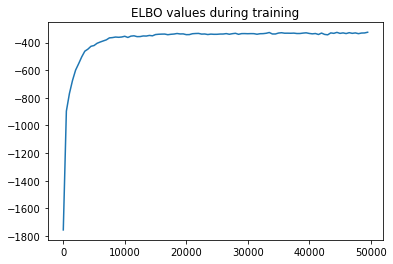

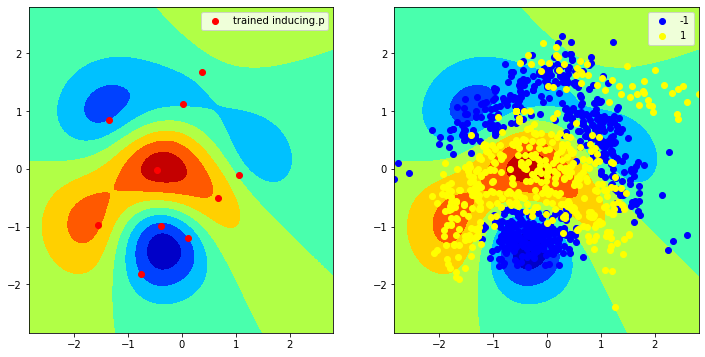

In [7]:


def plot_losses(losses, num_steps):
    plt.plot(np.arange(0, num_steps, 500), -np.array(losses))
    plt.title("ELBO values during training")
    plt.show()


def plot_prediction(model):
    # create new input points on grid
    n_grid = 100
    x = np.linspace(X.min(), X.max(), n_grid)
    X1new, X2new = np.meshgrid(x, x)
    Xnew = np.hstack(
        [X1new.reshape(-1, 1), X2new.reshape(-1, 1)]
    )  # size : n_grid * n_grid x 2

    plt.figure(figsize=(12, 6))

    pos_m, pos_v = model.predict_f(Xnew)
    pdf = pos_m.numpy() / np.sqrt(1 + pos_v.numpy())
    plt.subplot(1, 2, 1)
    plt.contourf(X1new, X2new, pdf.reshape((n_grid, n_grid)), cmap="jet")
    plt.scatter(model.X_s[:, 0], model.X_s[:, 1],
                c="red", label="trained inducing.p")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.contourf(X1new, X2new, pdf.reshape((n_grid, n_grid)), cmap="jet")
    for g, c in zip([-1, 1], ["blue", "yellow"]):
        ix = np.where(Y == g)
        plt.scatter(model.X[ix, 0], model.X[ix, 1], color=c, label=str(g))
    plt.legend()
    plt.show()


print(model.kernel.alpha, model.kernel.scale)
plot_losses(losses, num_steps)
plot_prediction(model)

### Animate

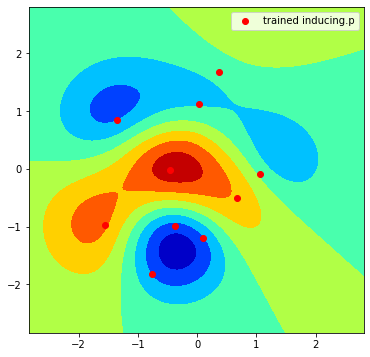

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# create new input points on grid
n_grid = 100
x = np.linspace(X.min(), X.max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack(
    [X1new.reshape(-1, 1), X2new.reshape(-1, 1)]
)  # size : n_grid * n_grid x 2


def plot_prediction_animation(model, X_s, posterior, ax):
    pos_m, pos_v = model._predict_f(Xnew, X_s, *posterior)
    pdf = pos_m.numpy() / np.sqrt(1 + pos_v.numpy())
    ax.contourf(X1new, X2new, pdf.reshape((n_grid, n_grid)), cmap="jet")
    ax.scatter(X_s[:, 0], X_s[:, 1], c="red", label="trained inducing.p")
    ax.legend()


def animate(i):
    ax.cla()  # clear the previous image
    plot_prediction_animation(
        model,
        inducing_points[i],
        posteriors[i],
        ax,
    )


anim = ani.FuncAnimation(fig, animate, frames=len(
    losses), interval=1, blit=False)
HTML(anim.to_jshtml())